In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from glob import iglob

In [2]:
import importlib
import src.pipeline as pipeline

In [12]:
importlib.reload(pipeline)

<module 'src.pipeline' from '/Users/vinsonmccready/galvanize/loan-default-predictor/src/pipeline.py'>

In [3]:
data = pipeline.get_all_data('data/raw/')

In [4]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,year
0,145217616,NaN,10000,10000,10000.0,36 months,10.33%,324.23,B,B1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18
1,145640422,NaN,2500,2500,2500.0,36 months,13.56%,84.92,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18
2,145630143,NaN,12000,12000,12000.0,60 months,13.56%,276.49,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18
3,145127870,NaN,15000,15000,14975.0,60 months,14.47%,352.69,C,C2,...,Oct-99,0.0,0.0,16.0,48.8,15.0,0.0,0.0,NaN,18
4,145558466,NaN,16000,16000,16000.0,60 months,17.97%,406.04,D,D1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18


In [5]:
data['loan_status'].value_counts()

Current               2086919
Fully Paid             552459
Charged Off            131231
Late (31-120 days)      32304
In Grace Period         22089
Issued                  21294
Late (16-30 days)        8147
Default                    29
Name: loan_status, dtype: int64

In [6]:
data['application_type'].value_counts()

INDIVIDUAL    1359464
Individual    1284175
Joint App      194206
JOINT           13707
DIRECT_PAY       2920
Name: application_type, dtype: int64

In [14]:
# Only use individual loan types
data = pipeline.filter_data(data)
data['application_type'].unique()

In [8]:
data.shape[0]

673340

In [9]:
all_data.shape[0]

2854472

In [15]:
# Columns with missing data

data[data.columns[data.isnull().sum()/data.shape[0] > .2]].isnull().sum()/data.shape[0]

member_id                              1.000000
desc                                   0.963374
mths_since_last_delinq                 0.519161
mths_since_last_record                 0.850447
next_pymnt_d                           0.254702
mths_since_last_major_derog            0.744397
annual_inc_joint                       1.000000
dti_joint                              1.000000
verification_status_joint              1.000000
open_acc_6m                            0.311407
open_il_12m                            0.311406
open_il_24m                            0.311406
mths_since_rcnt_il                     0.331586
total_bal_il                           0.311406
il_util                                0.407763
open_rv_12m                            0.311406
open_rv_24m                            0.311406
max_bal_bc                             0.311406
all_util                               0.311497
inq_fi                                 0.311406
total_cu_tl                            0

In [8]:
drop = ['member_id', 
        'desc', 'next_pymnt_d', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 
        'revol_bal_joint', 'sec_app_fico_range_low', 
        'sec_app_fico_range_high',
        'sec_app_earliest_cr_line', 
        'sec_app_inq_last_6mths',
        'sec_app_mort_acc', 
        'sec_app_open_acc',
        'sec_app_revol_util',
#         'sec_app_open_il_6m', 
        'sec_app_num_rev_accts',
        'sec_app_chargeoff_within_12_mths',
        'sec_app_collections_12_mths_ex_med',
        'sec_app_mths_since_last_major_derog',
        'funded_amnt_inv', 
        'grade',
        'emp_title', 
        'emp_length',
        'pymnt_plan',
        'url',
        'title',
        'zip_code',
        'addr_state',
        'earliest_cr_line',
        'fico_range_high',
        'initial_list_status',
        'out_prncp',
        'out_prncp_inv',
        'total_pymnt',
        'total_pymnt_inv',
        'total_rec_prncp',
        'total_rec_int',
        'total_rec_late_fee',
        'recoveries',
        'collection_recovery_fee',
        'last_credit_pull_d', 
        'last_pymnt_d',
        'last_pymnt_amnt',
        'next_pymnt_d',
        'acc_now_delinq',
        'tot_coll_amt',
        'tot_cur_bal',
        'delinq_amnt' 
       ]
# data = data.drop(drop, axis=1)

In [16]:
data.purpose.unique()

array(['debt_consolidation', 'credit_card', 'home_improvement', 'other',
       'major_purchase', 'vacation', 'house', 'car', 'small_business',
       'renewable_energy', 'medical', 'moving', 'wedding', 'educational'],
      dtype=object)

In [17]:
# Missing values
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

'member_id': number of missing values '2643639' ==> '100.000%'
'emp_title': number of missing values '221805' ==> '8.390%'
'emp_length': number of missing values '172991' ==> '6.544%'
'desc': number of missing values '2546814' ==> '96.337%'
'title': number of missing values '22178' ==> '0.839%'
'zip_code': number of missing values '1' ==> '0.000%'
'inq_last_6mths': number of missing values '1' ==> '0.000%'
'mths_since_last_delinq': number of missing values '1372475' ==> '51.916%'
'mths_since_last_record': number of missing values '2248274' ==> '85.045%'
'revol_util': number of missing values '2053' ==> '0.078%'
'last_pymnt_d': number of missing values '20363' ==> '0.770%'
'next_pymnt_d': number of missing values '673340' ==> '25.470%'
'last_credit_pull_d': number of missing values '77' ==> '0.003%'
'mths_since_last_major_derog': number of missing values '1967916' ==> '74.440%'
'annual_inc_joint': number of missing values '2643639' ==> '100.000%'
'dti_joint': number of missing values '2

<AxesSubplot:>

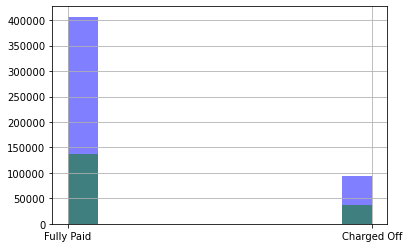

In [13]:
fig, ax = plt.subplots()

data[data['mths_since_last_major_derog'].isna()]['loan_status'].hist(ax = ax, alpha=.5, color='blue')
data[~data['mths_since_last_major_derog'].isna()]['loan_status'].hist(ax = ax, alpha=.5, color='green')

<AxesSubplot:>

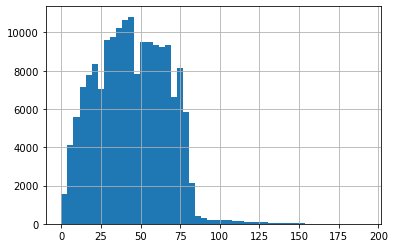

In [14]:
data['mths_since_last_major_derog'].hist(bins = 50)

In [20]:
# Clean data

data = pipeline.clean_data(data)

In [21]:
# Create Test and Validation Set

data['year'].unique()

array([18, 13, 12, 14, 15, 20, 19, 17, 16])

<BarContainer object of 9 artists>

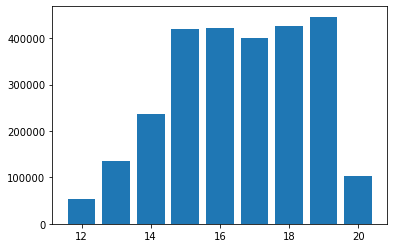

In [22]:
fig, ax = plt.subplots()

ax.bar(data['year'].value_counts().index,data['year'].value_counts() )

In [23]:
(data['year'] >= 17).sum()/data.shape[0]

0.5206917434642173

In [18]:
(data[data['year'] >= 17]['loan_status']=='Charged Off').sum()/data[data['year'] >= 17].shape[0]

0.08287779507415319

In [20]:
(data[data['year'] < 17]['loan_status']=='Charged Off').sum()/data[data['year'] < 17].shape[0]

0.2085436880049994

In [21]:
data[data['loan_status']=='Charged Off'].groupby('year')['year'].count()/data.groupby('year')['year'].count()

year
12    0.164491
13    0.160649
14    0.205134
15    0.264148
16    0.202681
17    0.118006
18    0.051843
19    0.044889
20    0.008303
Name: year, dtype: float64

In [54]:
validation = data[data['year'] >= 17]

In [39]:
drop.extend([
    'application_type', 
    'issue_d', 
    'id',
    'loan_status',
    'year'])

In [55]:
training = pipeline.completed_filter(data[data['year'] < 17])

In [56]:

X_train = pipeline.create_X(training, drop)
y_train = pipeline.create_y(training)

In [57]:
X_test = pipeline.create_X(pipeline.completed_filter(validation), drop)
y_test = pipeline.create_y(pipeline.completed_filter(validation))

In [58]:
print(X_train.shape)
print(X_test.shape)

(590471, 126)
(82869, 122)


In [59]:
for c in X_train.columns:
    if c not in X_test.columns:
        print(c)

home_ownership_NONE
home_ownership_OTHER
purpose_educational
purpose_wedding


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import recall_score, precision_score

In [340]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [42]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
recall = recall_score(y_test, rf_model.predict(X_test))
precision = precision_score(y_test, rf_model.predict(X_test))
print(f'Recall: {recall}\nPrecision: {precision}')

ValueError: X has 122 features, but DecisionTreeClassifier is expecting 126 features as input.

In [ ]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
recall = recall_score(y_test, gb_model.predict(X_test))
precision = precision_score(y_test, gb_model.predict(X_test))
print(f'Recall: {recall}\nPrecision: {precision}')

In [ ]:
def calculate_threshold_values(prob, y):
    '''
    Build dataframe of the various confusion-matrix ratios by threshold
    from a list of predicted probabilities and actual y values
    '''
    df = pd.DataFrame({'prob': prob, 'y': y})
    df.sort_values('prob', inplace=True)
    
    actual_p = df.y.sum()
    actual_n = df.shape[0] - df.y.sum()

    df['tn'] = (df.y == 0).cumsum()
    df['fn'] = df.y.cumsum()
    df['fp'] = actual_n - df.tn
    df['tp'] = actual_p - df.fn

    df['fpr'] = df.fp/(df.fp + df.tn)
    df['tpr'] = df.tp/(df.tp + df.fn)
    df['precision'] = df.tp/(df.tp + df.fp)
    df = df.reset_index(drop=True)
    return df
    
def plot_roc(ax, df):
    ax.plot([1]+list(df.fpr), [1]+list(df.tpr), label="ROC")
    ax.plot([0,1],[0,1], 'k', label="random")
    ax.set_xlabel('fpr')
    ax.set_ylabel('tpr')
    ax.set_title('ROC Curve')
    ax.legend()
    
def plot_precision_recall(ax, df):
    ax.plot(df.tpr,df.precision, label='precision/recall')
    #ax.plot([0,1],[0,1], 'k')
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision/Recall Curve')
    ax.plot([0,1],[df.precision[0],df.precision[0]], 'k', label='random')
    ax.set_xlim(left=0,right=1)
    ax.set_ylim(bottom=0,top=1)

In [ ]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6))
df = calculate_threshold_values(rf_model.predict_proba(X_test)[:,1], y_test)
plot_roc(ax0, df)
plot_precision_recall(ax1, df)

In [ ]:
probabilities = rf_model.predict_proba(X_test)

In [ ]:
fig, ax = plt.subplots()
ax.hist(probabilities[:,1], bins=50);

In [ ]:
(probabilities > .5).sum()

In [ ]:
y.sum()

In [ ]:
threshold = np.linspace(0,1,50)
yhat = rf_model.predict_proba(X_test)[:,1]

recall = []
precision = []
for t in threshold:
    c = pd.crosstab(pd.Categorical(y_test, categories=[0,1]), 
                    pd.Categorical(yhat>t, categories=[0,1]), 
                    rownames=['actual'], 
                    colnames=['predicted'],
                    dropna=False)
    r = c[1][1]/(c[1][1]+c[0][1])
    p = c[1][1]/(c[1][1]+c[1][0])
    recall.append(r)
    precision.append(p)

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(threshold, recall, label='recall')
ax.plot(threshold, precision, label='precision')
# ax.vlines([.08, .85], 0,1, linestyles='--', colors='green')
ax.legend()
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Change in Precision and Recall for Thresholds')
plt.show()

In [ ]:
y_prob = rf_model.predict_proba(X_test)[:,1]

In [ ]:
# make predictions based on probabilities and threshold
def predict(model, X, threshold=0.5):
    '''Return prediction of the fitted binary-classifier model model on X using
    the specifed `threshold`. NB: class 1 is the positive class'''
    return np.where(model.predict_proba(X)[:,1] > threshold, 1, 0)

# create confusion matrix with a given model and Xtest
def confusion_matrix(model, X, y,  threshold=0.5):
    cf = pd.crosstab(y, predict(model, X, threshold), dropna=False)
    cf = cf.add(pd.DataFrame([[0,0],[0,0]], columns=[0, 1], index=[0, 1]), fill_value=0)
    cf.index.name = 'actual'
    cf.columns.name = 'predicted'
    return cf

# calculate the payout for a given probability threshold
def calculate_payout(cb_matrix, model, X, y, threshold):
    return (confusion_matrix(model, X, y, threshold) * cb_matrix).values.sum()

In [ ]:
rf_model.classes_

In [ ]:
cf = confusion_matrix(rf_model, X_test, y_test)

In [ ]:
cf

In [ ]:
cb_matrix = pd.DataFrame([[0, -20], [0, 10]], columns=[0, 1], index=[0,1])
cb_matrix.index.name = 'actual'
cb_matrix.columns.name = 'predicted'

In [ ]:
cb_matrix

In [ ]:
calculate_payout(cb_matrix, rf_model, X_test, y_test, .5)

In [ ]:
-10*6414 + 26550 * 10

In [ ]:
# Cost benefit
def get_profits(model, X, y):
    cb_matrix = pd.DataFrame([[0, -20], [0, 10]], columns=[0, 1], index=[0,1])
    cb_matrix.index.name = 'actual'
    cb_matrix.columns.name = 'predicted'
    # calculate the payout with a the cost benefit matrix, 
    # given threshhold, model, and X
    thresholds = np.arange(0.0, 1.0, 0.05)
    profits = []
    for threshold in thresholds:
        profits.append(calculate_payout(cb_matrix, model, X, y, threshold))
    return profits
    
    
def profit_curve(profits, ax):
    thresholds = np.arange(0.0, 1.0, 0.05)
    ax.plot(thresholds, profits)
    ax.set_xlabel('Thresholds')
    ax.set_ylabel('Profits')
    ax.set_title('Profit Curve')
    print(profits)

In [ ]:
profits = get_profits(rf_model, X_test, y_test)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
thresholds = np.arange(0.0, 1.0, 0.05)
ax.plot(thresholds, profits)
ax.set_xlabel('Thresholds')
ax.set_ylabel('Profits')
ax.set_title('Profit Curve')
ax.set_ylim(-250000, 200000)

In [ ]:
def get_yhat(probs, threshold):
    return probs > threshold

In [ ]:
def get_cf_arrays(y_true, y_hat):
    true_positive = (y_true == 1) & (y_hat==1)
    true_negative = (y_true == 0) & (y_hat==0)
    false_positive = (y_true == 0) & (y_hat==1)
    false_negative = (y_true == 1) & (y_hat==0)
    return true_positive, true_negative, false_positive, false_negative

In [ ]:
tp, tn, fp, fn = get_cf_arrays(y_test, get_yhat(probabilities[:,1], .65))

In [ ]:
tp.sum() + tn.sum() + fp.sum() + fn.sum()

In [ ]:
y_test.shape[0]

In [ ]:
data.loc[y_test.index[tp]]

In [ ]:
payment = [
    'loan_amnt', 
    'funded_amnt',
    'out_prncp',
    'out_prncp_inv',
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_prncp',
    'total_rec_int',
    'total_rec_late_fee']

In [ ]:
data.loc[y_test.index[tp]][payment]

In [ ]:
data[data.loan_amnt != data.funded_amnt][payment]

In [ ]:
data.loc[:,payment].info()

In [ ]:
(data.loc[y_test.index[tp]]['funded_amnt'].sum()-data.loc[y_test.index[tp]]['total_rec_prncp'].sum())/y_test.index[tp].shape[0]

In [ ]:
data.loc[y_test.index[fp]]['total_rec_int'].sum()

In [ ]:
def potential_principal_saved(tp, fp, interest=False):
    # Principal remaining
    funded = data.loc[y_test.index[tp]]['funded_amnt'].sum()
    princ_rec = data.loc[y_test.index[tp]]['total_rec_prncp'].sum()
    int_rec = data.loc[y_test.index[tp]]['total_rec_int'].sum()
    missed_int = data.loc[y_test.index[fp]]['total_rec_int'].sum()
    saved = funded - princ_rec - missed_int
    if interest:
        saved -= int_rec
    return saved
    

In [ ]:
savings = []
for t in threshold:
    tp, tn, fp, fn = get_cf_arrays(y_test, get_yhat(probabilities[:,1], t))
    savings.append(potential_principal_saved(tp, fp))

In [ ]:
fig, ax = plt.subplots()

ax.plot(threshold, savings)

In [ ]:
savings = []
for t in threshold:
    tp, tn, fp, fn = get_cf_arrays(y_test, get_yhat(probabilities[:,1], t))
    savings.append(potential_principal_saved(tp, fp, True))


In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(threshold, savings)
ax.set_xlabel('Threshold')
ax.set_ylabel('Dollars Saved')

In [ ]:
threshold[np.argmax(savings)]